# Notebook Disclaimer

This notebook is based on open-access code shared by Martin Görner on GitHub. The original source code can be found at [https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/07_training/07b_gpumax.ipynb].

**Disclaimer:** This notebook is for educational purposes and follows the principles of fair use. The code is the intellectual property of the original author, and any modifications or adaptations made here are done solely for learning and personal use. All credits for the original code go to Martin Görner.

Please refer to the original repository for detailed explanations, and support the author by exploring their work on [https://github.com/GoogleCloudPlatform/practical-ml-vision-book].

---



### Ingest code

In [3]:
%%writefile input.txt
gs://practical-ml-vision-book/images/california_fire1.jpg
gs://practical-ml-vision-book/images/california_fire2.jpg

Writing input.txt


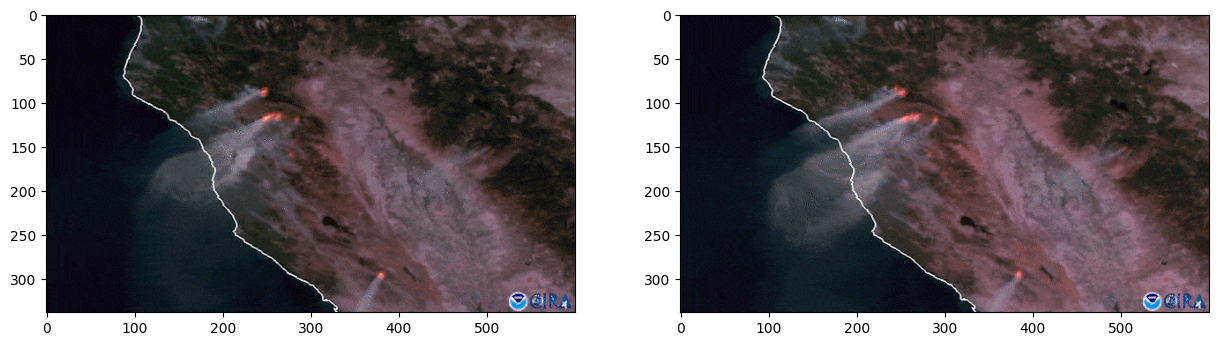

In [5]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

def read_jpeg(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.reshape(img, [338, 600, 3])
    return img

ds = tf.data.TextLineDataset('input.txt').map(read_jpeg)
f, ax = plt.subplots(1, 2, figsize=(15,10))
for idx, img in enumerate(ds):
    ax[idx].imshow( img.numpy() );

Add map function

(338, 600)


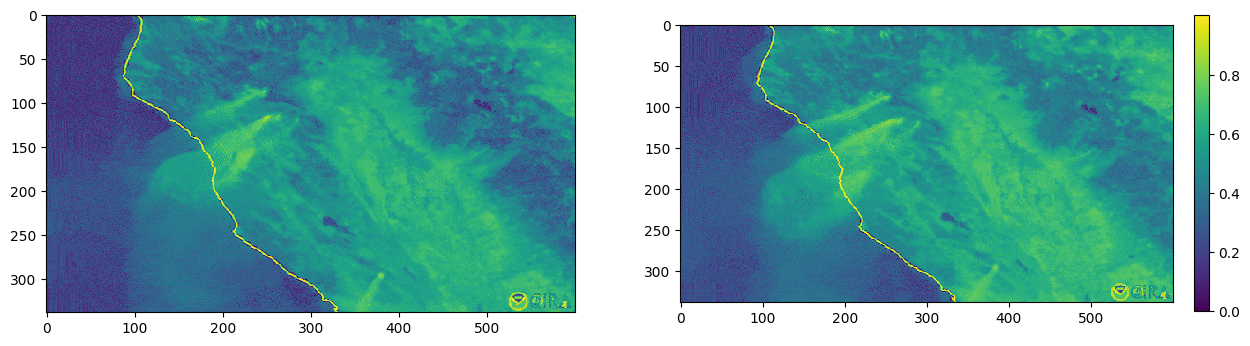

In [7]:
## Map function with custom formula
def to_grayscale(img):
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    print(gray.shape)
    return gray

ds = tf.data.TextLineDataset('input.txt').map(read_jpeg).map(to_grayscale)
f, ax = plt.subplots(1, 2, figsize=(15,10))
for idx, img in enumerate(ds):
    im = ax[idx].imshow( img.numpy() , interpolation='none');
    if idx == 1:
        f.colorbar(im, fraction=0.028, pad=0.04)

#### Test 1. Iterate thourgh the image

In [8]:
# This function is not accelerated. At all.
def to_grayscale(img):
    rows, cols, _ = img.shape
    result = np.zeros([rows, cols], dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            red = img[row][col][0]
            green = img[row][col][1]
            blue = img[row][col][2]
            c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
            if c_linear > 0.0031308:
                result[row][col] = 1.055 * pow(c_linear, 1/2.4) - 0.055
            else:
                result[row][col] = 12.92*c_linear
    return result

In [10]:
%%time
# Create a tensorflow dataset  to measure time take tranforming to numpy and then to gray
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg)

overall = tf.constant([0.], dtype=tf.float32)
count = 0
for img in ds:
    # Notice that we have to call .numpy() to move the data outside TF Graph
    gray = to_grayscale(img.numpy())
    # This moves the data back into the graph
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331078], shape=(1,), dtype=float32)
CPU times: total: 36.1 s
Wall time: 36.2 s


#### Test 2. using pyfunc

In [12]:
def to_grayscale_numpy(img):
    # the numpy happens here
    img = img.numpy()
    rows, cols, _ = img.shape
    result = np.zeros([rows, cols], dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            red = img[row][col][0]
            green = img[row][col][1]
            blue = img[row][col][2]
            c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
            if c_linear > 0.0031308:
                result[row][col] = 1.055 * pow(c_linear, 1/2.4) - 0.055
            else:
                result[row][col] = 12.92*c_linear
    # the convert back happens here
    return tf.convert_to_tensor(result)

def to_grayscale(img):
    return tf.py_function(to_grayscale_numpy, [img], tf.float32)

#### Test 3. Using tensorflow slicing and tf.where

In [13]:
# All in GPU
def to_grayscale(img):
    # TensorFlow slicing functionality
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    # All these are actually tf.mul(), tf.add(), etc.
    c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    # Use tf.cond and tf.where for if-then statements
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    return gray

In [14]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).map(to_grayscale)

overall = tf.constant([0.])
count = 0
for gray in ds:
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331072], shape=(1,), dtype=float32)
CPU times: total: 1.89 s
Wall time: 3.31 s


#### Test 4. Using Matrix math and tf.where

In [15]:
def to_grayscale(img):
    wt = tf.constant([[0.2126], [0.7152], [0.0722]]) # 3x1 matrix
    c_linear = tf.matmul(img, wt) # (ht,wd,3) x (3x1) -> (ht, wd)
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    return gray

In [16]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).map(to_grayscale)

overall = tf.constant([0.])
count = 0
for gray in ds:
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331072], shape=(1,), dtype=float32)
CPU times: total: 2 s
Wall time: 3.15 s


#### Test 5. Batching

In [20]:
class Grayscale(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Grayscale, self).__init__(**kwargs)
    
    def call(self, img):
        wt = tf.constant([[0.2126], [0.7152], [0.0722]]) # 3x1 matrix
        c_linear = tf.matmul(img, wt) # (N, ht,wd,3) x (3x1) -> (N, ht, wd)
        gray = tf.where(c_linear > 0.0031308,
                        1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                        12.92*c_linear)
        return gray # (N, ht, wd)

model = tf.keras.Sequential([
    Grayscale(input_shape=(338, 600, 3)),
    tf.keras.layers.Lambda(lambda gray: tf.reduce_mean(gray, axis=[1, 2])) # note axis change
])

In [21]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).batch(5)
overall = tf.constant([0.])
count = 0
for batch in ds:
    bm = model(batch)
    overall += tf.reduce_sum(bm)
    count += len(bm)
print(overall/count)

tf.Tensor([0.46331078], shape=(1,), dtype=float32)
CPU times: total: 2.3 s
Wall time: 3.25 s
